This project focused on differential gene expression analysis. We will utilize an unsupervised learning approach, using K-Means clustering to find the hidden patterns inside the datasets and form clusters based on genes co-expression under condition of SARS infection.

The dataset includes readings of fluorescence tags emissions from the microarray gene expression analysis method. ID_REF column refers to the sample slot ids, and the corresponding columns represent reading intensities from control and infected sets.

# First, let's install some of the required libraries.


In [ ]:
pip install pandas


In [2]:
pip install -U scikit-learn

     |████████████████████████████████| 22.3 MB 35 kB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


# Importing libraries

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('max_seq_item', None)
pd.set_option('display.width', 1000)

# Importing the file:

In [4]:
!wget https://raw.githubusercontent.com/dmy-collab/shared-projects/main/Hidden_genetical_patterns_SARS_virus/SARS_expression.csv
dataset = pd.read_csv('SARS_expression.csv')

--2021-08-03 17:01:08--  https://raw.githubusercontent.com/dmy-collab/shared-projects/main/Hidden_genetical_patterns_SARS_virus/SARS_expression.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 235271 (230K) [text/plain]
Saving to: ‘SARS_expression.csv.1’

SARS_expression.csv 100%[===================>] 229.76K  --.-KB/s    in 0.01s   

2021-08-03 17:01:08 (16.8 MB/s) - ‘SARS_expression.csv.1’ saved [235271/235271]



# Initial analysis:

In [5]:
print(dataset.shape)
print(dataset.head())
print(dataset.describe())
nulls = dataset.isnull().sum().to_frame()   # searching for missing values
for index, row in nulls.iterrows():
    print(index, row[0])

(3949, 9)
      ID_REF  Control_1  Control_2  Control_3  Control_4  SARS_Infected_1  SARS_Infected_2  SARS_Infected_3  SARS_Infected_4
0  1007_s_at      321.8      257.1      331.0      366.8            205.2            223.9            262.1            313.5
1    1053_at      204.8      293.5      217.4      261.8            215.8            265.6             56.1            203.5
2     117_at      538.6      367.0      529.0      362.1            561.1            365.4            275.6           1037.3
3     121_at     1277.8      880.2     1031.8     1036.1            790.9           1016.1           1165.7           1189.1
4    1294_at      645.1      593.9      673.9      702.3            628.2            511.1            280.9            690.1
          Control_1     Control_2     Control_3     Control_4  SARS_Infected_1  SARS_Infected_2  SARS_Infected_3  SARS_Infected_4
count   3949.000000   3949.000000   3949.000000   3949.000000      3949.000000      3949.000000      3949.0000



# Separating values for infected samples:



In [6]:
new_data = dataset.iloc[:, 5:]
print(new_data.head())

   SARS_Infected_1  SARS_Infected_2  SARS_Infected_3  SARS_Infected_4
0            205.2            223.9            262.1            313.5
1            215.8            265.6             56.1            203.5
2            561.1            365.4            275.6           1037.3
3            790.9           1016.1           1165.7           1189.1
4            628.2            511.1            280.9            690.1


# Determining the optimal value of K using the "elbow" method:

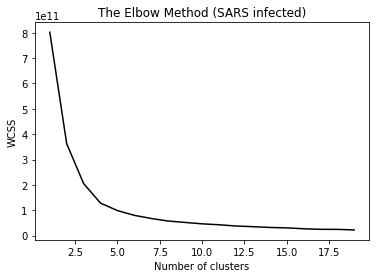


 cluster labels: [16 16 16 ... 17  8  8]


In [7]:
wcss = []   # within cluster sum of squares (measures the variability of the observations within each cluster)
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=150)
    kmeans.fit(new_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 20), wcss, color='k')
plt.title("The Elbow Method (SARS infected)")
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()      
print(f'\n cluster labels: {kmeans.labels_}')

*From the graph, we can infer that 18 - is the optimal number of clusters (adding more clusters wouldn't provide much better modeling of the data). Let's assign this cluster number to the to the GenBank  accession IDs:*


# Let's assign the cluster number retrieved from the step above to the ID_REF:

In [8]:
cluster_genes =\
    pd.concat([dataset.iloc[:, 0], pd.DataFrame(kmeans.labels_)], axis=1)
cluster_genes.columns = ['ID_REF', 'Groups']
print(cluster_genes.head())

      ID_REF  Groups
0  1007_s_at      16
1    1053_at      16
2     117_at      16
3     121_at      12
4    1294_at      16


# Grouping genes into respective clusters:

In [9]:
cluster = cluster_genes.groupby('Groups')
print(cluster.describe()) 

       ID_REF                                 
        count unique                  top freq
Groups                                        
0         209    209            201256_at    1
1           6      6            201094_at    1
2          19     19          200099_s_at    1
3           2      2       AFFX-CreX-3_at    1
4          10     10          200834_s_at    1
5          30     30          201315_x_at    1
6          50     50          202803_s_at    1
7          96     96          208697_s_at    1
8           2      2  AFFX-r2-P1-cre-5_at    1
9           3      3          214414_x_at    1
10          1      1          202917_s_at    1
11          6      6            200021_at    1
12        895    895          208783_s_at    1
13         18     18          206390_x_at    1
14         52     52          201553_s_at    1
15          7      7          216526_x_at    1
16       2376   2376          202666_s_at    1
17          4      4      AFFX-BioDn-3_at    1
18        163

*Cluster 0 has the highest N of genes - 2739. Let's retrieve this cluster:*

In [10]:
cluster = {k: v for k, v in cluster_genes.groupby('Groups')}
print('\nCluster with the highest number of genes:\n')
print(cluster[0])


Cluster with the highest number of genes:

           ID_REF  Groups
10      200001_at       0
14      200005_at       0
50    200041_s_at       0
57    200048_s_at       0
63      200055_at       0
...           ...     ...
3857     36994_at       0
3858     37012_at       0
3860     37145_at       0
3908     55705_at       0
3920     90610_at       0

[209 rows x 2 columns]


This information provides a solid starting point for further research supported with literature and the pathway analysis of these genes, along with the gene enrichment analysis.